In this notebook I applied geopandas and pandas to plot background map, the IRS seismic data, and the Focal mechanism beach balls. \
* - earthquake origin date and time;
* - epicentre (lat,lon);
*- error ellipse parameters (smajax, sminax, strike), epicentre quality (q:A(highest)/B/C);
* - depth, depth uncertainty (unc), depth quality (q:A(highest)/B/C);
* - Mw, Mw uncertainty (unc), quality (q:A(highest)/B/C), source(s:p-proxy, d-direct computation);
* - where available: scalar moment (mo), factor (fac) in Nm, mo author (mo_auth), six moment tensor components (mpp, mpr, mrr, mrt, mtp, mtt),
*  nodal planes (str1, dip1, rake1, str2, dip2, rake2) and type (BDC = best double-couple; BB = broadband analysis, FM = first motion polarities; RA = relative amplitudes ; unknown if null);
* - event identifier.


In [238]:
#should be activate mysw4 conda env
import pandas as pd 
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, LineString
import seaborn as sns
import numpy as np
%matplotlib inline
names=[ 'date','lat','lon','smajax' , 'sminax' , 'strike', 'loc_q' , 'depth' ,'depth_unc' , 'depth_q' ,
        'mw',  'mw_unc' , 'mw_q' , 'source' ,'mo','fac', 'mo_auth','mpp','mpr','mrr','mrt','mtp','mtt' 
        ,'str1','dip1','rake1','str2','dip2','rake2','type','eventid' ]

df1 = pd.read_csv("/localdata/rayan/ISC_cataloges_2020/isc-gem-cat.csv",error_bad_lines=False,
               skiprows=lambda x: x in [0, 95], skipinitialspace=True , 
               names=names,
               comment='#'
               )
df1['date']=pd.to_datetime(df1.date)
df1['year']=df1['date'].dt.year
df1['month']=df1['date'].dt.month
df1['day']=df1['date'].dt.day
df1['hour']=data['date'].dt.hour
sns.set_style('whitegrid')
sns.set_context('talk')

In [169]:

##lon1,lon2,lat1,lat2 for USA
R=[-60.00,-120.00,20.00,60.00]
mw=80
df_fm=df1[["strike","dip2","rake2","lat","lon"]]
df=df1[(df1['lon']<R[0]) & (df1['lon']>R[1])&(df1['lat']>R[2]) & (df1['lat']<R[3])&(df1['mw']<mw)]
#df.head()
##to use clip comment
polygon = Polygon([(-35, 0), (-35, 60), (60, 60), (60, 0), (0, 0)]);
polygon_US=Polygon([(-125, 15), (-125, 70), (-10, 70), (-10,15)]);

# Functions

In [435]:
# function to plot a boxplot and a histogram along the same scale.
def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None,color='brown'):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color=color
    )  # boxplot will be created and a star will indicate the mean value of the column
    ax_box2.set(xlabel='')
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="hsv"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

# function to create labeled barplots



def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

In [310]:

def fault_type(rake):
    type='None'
    if rake==0 or rake == 180:
        type='ss'
    elif rake==90:
        type='reverse'
    elif rake==-90:
        type='normal' 
    elif rake >-45 and rake <=45:
        type='ss'  
    elif rake >45 and rake <=135:
        type='reverse'
    elif rake >135 and rake <=180:
        type='ss' 
    elif rake >-135 and rake <=-45:
        type='normal'
    elif rake >-180 and rake <=-135:
        type='ss' 
    return (type)    
          
                   
print(type)    
             

normal


# Importing shapefiles 

In [173]:
#
#regions = gpd.read_file("/localdata/rayan/ISC_cataloges_2020/Countries_WGS84/Countries_WGS84.shp")
#print(regions.crs)



regions = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
plate_oregens=gpd.read_file("/localdata/rayan/ISC_cataloges_2020/tectonicplates-master/PB2002_orogens.shp")
plate_steps=gpd.read_file("/localdata/rayan/ISC_cataloges_2020/tectonicplates-master/PB2002_steps.shp")
plate_plates=gpd.read_file("/localdata/rayan/ISC_cataloges_2020/tectonicplates-master/PB2002_plates.shp")
plate_boundary=gpd.read_file("/localdata/rayan/ISC_cataloges_2020/tectonicplates-master/PB2002_boundaries.shp")
prov_lines_US=gpd.read_file("/localdata/rayan/ISC_cataloges_2020/tectonic_provinces_shapefile/prov_lines.shp")
physio_US=gpd.read_file("/localdata/rayan/ISC_cataloges_2020/physio_shapfile/physio.shp")
regions.head(2)

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."


In [174]:
physio_US.head(2)

,AREA,PERIMETER,PHYSIODD_,PHYSIODD_I,FCODE,FENCODE,DIVISION,PROVINCE,SECTION,PROVCODE,geometry
0,40.121,36.938,2,72,122,12b,INTERIOR PLAINS,CENTRAL LOWLAND,WESTERN LAKE,12,"POLYGON ((-103.00201 49.00395, -102.94103 49.0..."
1,21.976,39.951,3,59,131,13a,INTERIOR PLAINS,GREAT PLAINS,"MISSOURI PLATEAU, GLACIATED",13,"POLYGON ((-113.55362 48.99719, -112.19278 48.9..."


In [175]:
df1.head(1)

,date,lat,lon,smajax,sminax,strike,loc_q,depth,depth_unc,depth_q,...,rake1,str2,dip2,rake2,type,eventid,year,month,day,hour
0,1904-04-04 10:02:34.560,41.802,23.108,8.6,6.6,164.2,B,15.0,4.8,C,...,NaN,NaN,NaN,NaN,NaN,610326271,1904,4,4,NaN


the coordinate reference system: epsg:4326


Text(0.5, 1.0, 'Physiographic Division USA')

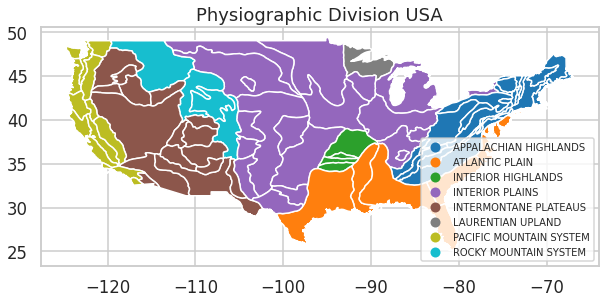

In [176]:
print('the coordinate reference system:',regions.crs) #coordinate reference system
fig,ax=plt.subplots(1,1,figsize=(10,9))
physio_US.plot(ax=ax,column='DIVISION',legend=True,legend_kwds={'loc':'lower right','fontsize':10});
plt.title('Physiographic Division USA')

## Plot the Plate boudaries (we can select any continent)

<AxesSubplot:>

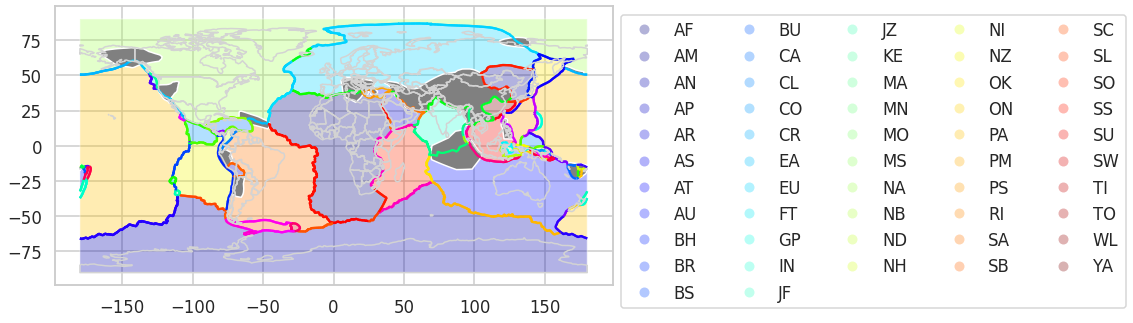

In [177]:
fig_test, ax_test=plt.subplots(figsize=(10,10))
plate_oregens.plot(ax=ax_test,column="Name",color='gray',zorder=3)
plate_steps.plot(ax=ax_test,column="PLATEBOUND",cmap='hsv',zorder=2)
plate_plates.plot(ax=ax_test,column="Code",cmap='jet',zorder=1,alpha=0.3,legend=True,legend_kwds=dict(loc='upper left', bbox_to_anchor=(1, 1),ncol=5))
plate_boundary.plot(ax=ax_test,column="Name",cmap='hsv',zorder=4)
regions.plot(ax=ax_test,facecolor="none", edgecolor="lightgray", linestyle='-',zorder=5)


## Convert the IRIS DataFrame to a GeoDataFrame

In [178]:
df_geo = gpd.GeoDataFrame(df1, geometry=gpd.points_from_xy(df1.lon, df1.lat))
# Set the coordinate reference system (CRS) to EPSG 4326
df_geo.crs = {'init': 'epsg:4326'}
#df_geo.crs = {'epsg':4326}

#df_geo.head()

In [179]:
#[df_geo.lat> R[3] & df_geo.lat <R[3] & df_geo.lon>R[0]  & df_geo.lon<R[1]]
df_geo_usa=df_geo[((df_geo.lat<= R[3]) & (df_geo.lat > R[2]))&(df_geo.lon<R[0])  & (df_geo.lon>R[1])]

## Plot Depth

Text(0.5, 1.0, 'Depth (km)')

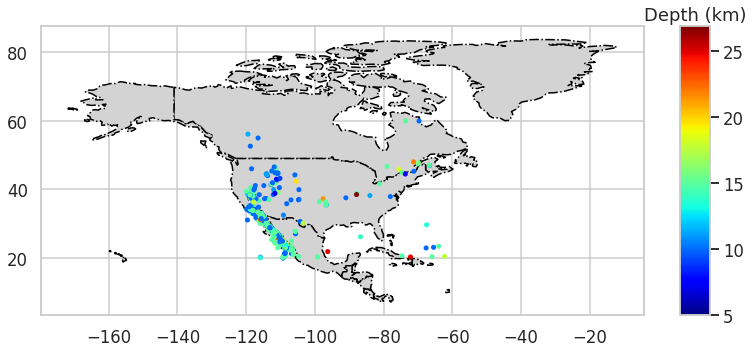

In [180]:
from mpl_toolkits.axes_grid1 import make_axes_locatable # to control the color bar
fig, ax = plt.subplots(figsize=(12,10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.5)
NA.plot(ax=ax,color='lightgray', linestyle='-.', edgecolor='black',zorder=1)
df_geo_usa.to_crs(epsg=4326).plot(markersize=50, ax=ax,column='depth',legend=True,cmap='jet',marker='.',zorder=2,cax=cax)
plt.title('Depth (km)')

## Plot magnitude 

Text(0.5, 1.0, 'Magnitude (Mw)')

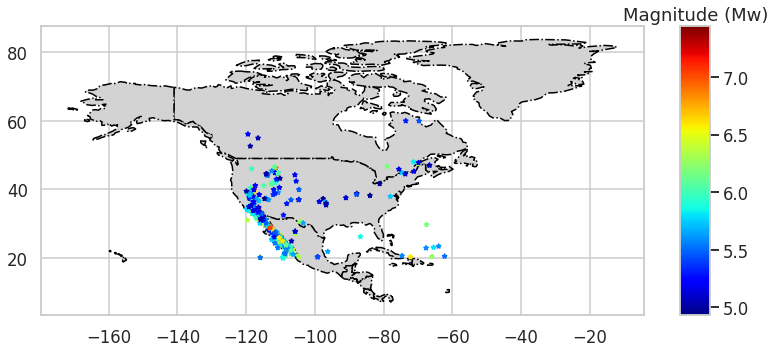

In [443]:
fig, ax = plt.subplots(figsize=(12,10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.5)
NA.plot(ax=ax,color='lightgray', linestyle='-.', edgecolor='black',zorder=1)
df_geo_usa.to_crs(epsg=4326).plot(markersize=20, ax=ax,column='mw',legend=True,cmap='jet',marker='*',zorder=2,cax=cax)
plt.title('Magnitude (Mw)')

## Clipping all the layers using clip method and polygon

Text(0.5, 1.0, 'EQ Depth (Km)')

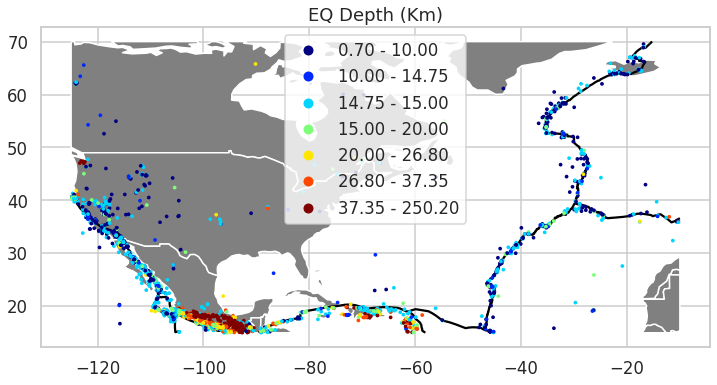

In [446]:
import mapclassify as mc


fig1, ax1 = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'});
clipped_R = gpd.clip(regions, polygon);
clipped_US = gpd.clip(regions, polygon_US);
clipped_E = gpd.clip(df_geo, polygon_US);
clipped_plates = gpd.clip(plate_boundary, polygon_US).plot(ax=ax1, facecolor="none", edgecolor="black",zorder=2)
clipped_US.plot(ax=ax1, color='gray',zorder=1);
clipped_E_Quant=mc.Quantiles(clipped_E['depth'],k=20);

#clipped_E.assign(cl=clipped_E_Quant.yb).plot(column='cl', categorical=True, \
#                              k=10, ax=ax1, cmap='jet',zorder=3,legend=True,markersize=5);

clipped_E.plot(column='depth',scheme='quantiles', \
                              k=10, ax=ax1, cmap='jet',zorder=3,legend=True,markersize=5);
plt.title('EQ Depth (Km)')

# Exploring EQ DATA

In [183]:
data=df_geo_usa
data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 447 entries, 60 to 39155
Data columns (total 36 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       447 non-null    datetime64[ns]
 1   lat        447 non-null    float64       
 2   lon        447 non-null    float64       
 3   smajax     447 non-null    float64       
 4   sminax     447 non-null    float64       
 5   strike     447 non-null    float64       
 6   loc_q      447 non-null    object        
 7   depth      447 non-null    float64       
 8   depth_unc  447 non-null    float64       
 9   depth_q    447 non-null    object        
 10  mw         447 non-null    float64       
 11  mw_unc     447 non-null    float64       
 12  mw_q       447 non-null    object        
 13  scalar     447 non-null    object        
 14  mo         265 non-null    float64       
 15  fac        265 non-null    float64       
 16  mo_auth    265 non-null    object

In [366]:
data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 447 entries, 60 to 39155
Data columns (total 37 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       447 non-null    datetime64[ns]
 1   lat        447 non-null    float64       
 2   lon        447 non-null    float64       
 3   smajax     447 non-null    float64       
 4   sminax     447 non-null    float64       
 5   strike     447 non-null    float64       
 6   loc_q      447 non-null    object        
 7   depth      447 non-null    float64       
 8   depth_unc  447 non-null    float64       
 9   depth_q    447 non-null    object        
 10  mw         447 non-null    float64       
 11  mw_unc     447 non-null    float64       
 12  mw_q       447 non-null    object        
 13  scalar     447 non-null    object        
 14  mo         265 non-null    float64       
 15  fac        265 non-null    float64       
 16  mo_auth    265 non-null    object

In [184]:
data.describe()

,lat,lon,smajax,sminax,strike,depth,depth_unc,mw,mw_unc,mo,...,dip1,rake1,str2,dip2,rake2,eventid,year,month,day,hour
count,447.000000,447.000000,447.000000,447.000000,447.000000,447.000000,447.000000,447.000000,447.000000,265.000000,...,252.000000,252.000000,252.000000,252.000000,252.000000,4.470000e+02,447.000000,447.000000,447.000000,447.000000
mean,31.903054,-110.707834,8.633110,5.583445,58.581879,12.806264,12.369128,5.814273,0.191834,3.872528,...,67.770635,2.367857,161.196825,74.532937,-18.521032,5.679218e+07,1977.243848,6.648770,16.521253,11.874720
std,7.162651,10.502512,6.004186,2.368050,37.995886,3.399796,9.976054,0.535302,0.112600,2.429038,...,19.912356,128.996652,93.115582,15.557389,96.396651,1.721588e+08,27.273915,3.261357,8.862369,7.013597
min,20.028000,-119.916000,2.100000,1.800000,0.200000,5.000000,0.700000,4.930000,0.100000,0.760000,...,10.000000,-180.000000,5.000000,30.000000,-180.000000,8.512000e+04,1906.000000,1.000000,1.000000,0.000000
25%,25.973000,-116.407500,5.300000,4.100000,37.700000,10.000000,3.800000,5.400000,0.100000,2.000000,...,51.000000,-103.000000,66.000000,63.750000,-90.000000,6.764405e+05,1956.000000,4.000000,9.000000,6.000000
50%,32.135000,-113.059000,6.900000,5.200000,48.300000,14.000000,5.700000,5.750000,0.200000,3.300000,...,75.000000,-3.000000,162.000000,80.500000,-6.500000,8.913570e+05,1980.000000,7.000000,17.000000,12.000000
75%,37.044500,-109.193000,10.250000,6.550000,63.700000,15.000000,25.000000,6.140000,0.240000,5.430000,...,85.000000,164.000000,224.000000,87.250000,14.000000,7.101884e+06,2003.000000,9.000000,24.000000,18.000000
max,59.954000,-62.280000,49.400000,17.400000,179.700000,26.900000,25.000000,7.440000,0.700000,13.410000,...,90.000000,180.000000,346.000000,90.000000,178.000000,6.150192e+08,2016.000000,12.000000,31.000000,23.000000


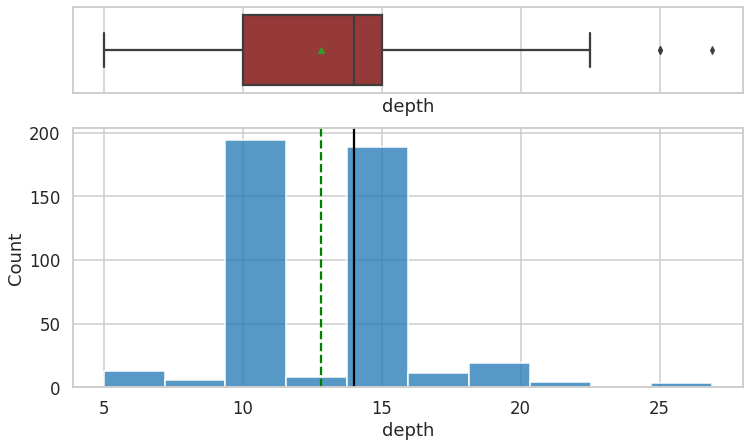

In [416]:
histogram_boxplot(data,'depth',bins=10)

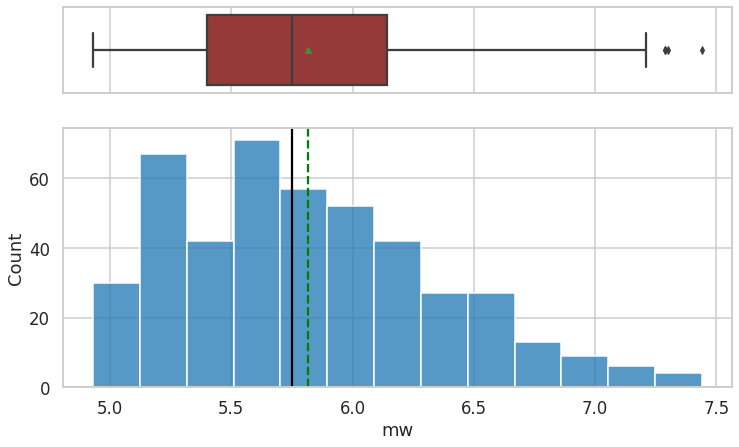

In [436]:
histogram_boxplot(data,'mw')

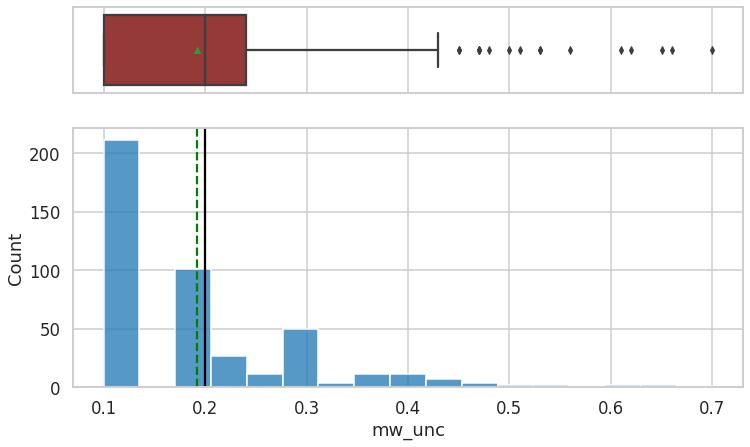

In [437]:
histogram_boxplot(data,'mw_unc')

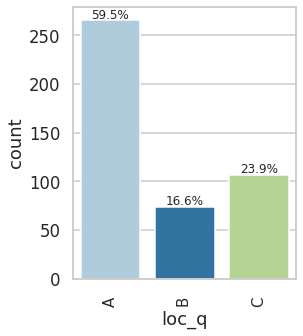

In [188]:
labeled_barplot(data, 'loc_q',perc=True)

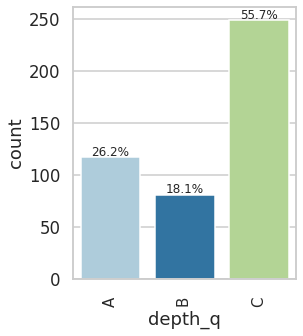

In [189]:
labeled_barplot(data, 'depth_q',perc=True) 

<AxesSubplot:xlabel='year', ylabel='mw'>

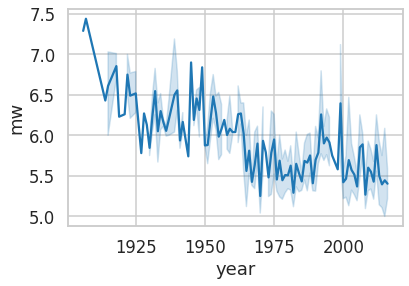

In [190]:
sns.lineplot(data=data,x='year',y='mw')

<AxesSubplot:xlabel='year', ylabel='mw_unc'>

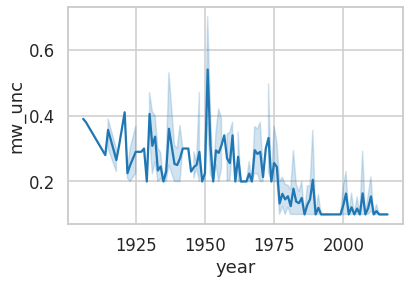

In [191]:
sns.lineplot(data=data,x='year',y='mw_unc')

<AxesSubplot:xlabel='year', ylabel='sminax'>

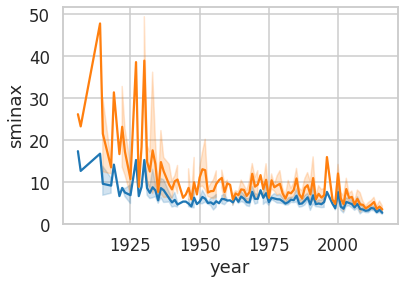

In [210]:
sns.lineplot(data=data,x='year',y='sminax',legend=True)
sns.lineplot(data=data,x='year',y='smajax',legend=True)

<AxesSubplot:xlabel='month', ylabel='mw_unc'>

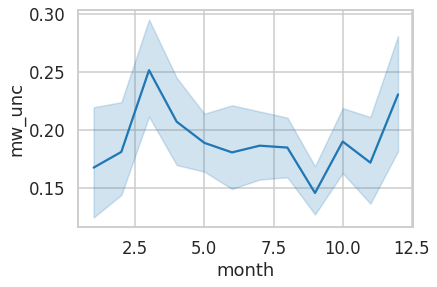

In [193]:
sns.lineplot(data=data,x='month',y='mw_unc')

<AxesSubplot:xlabel='month', ylabel='depth_unc'>

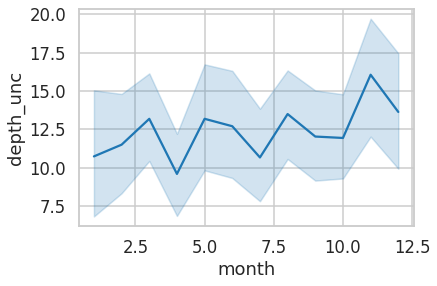

In [194]:
sns.lineplot(data=data,x='month',y='depth_unc')

<AxesSubplot:xlabel='hour', ylabel='depth_unc'>

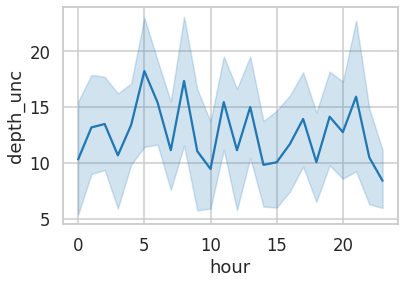

In [204]:
sns.lineplot(data=data,x=data['hour'],y='depth_unc')

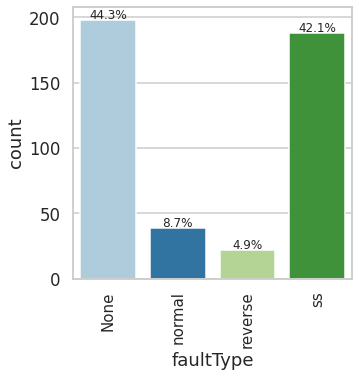

In [318]:
data['faultType']=data.rake1.apply(lambda x:fault_type(x))
labeled_barplot(data, 'faultType',perc=True) 

<AxesSubplot:xlabel='PROVINCE'>

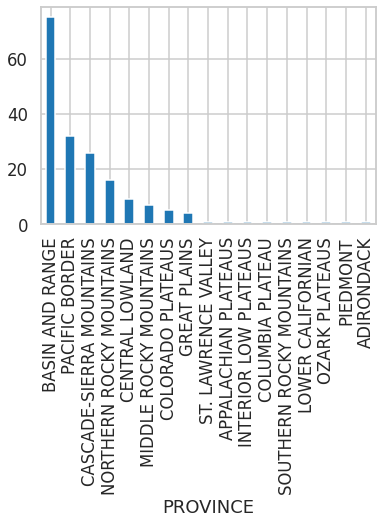

In [333]:
gpd.sjoin(data,physio_US).groupby('PROVINCE')['mw'].count().sort_values(ascending=False).plot.bar()

<AxesSubplot:xlabel='SECTION'>

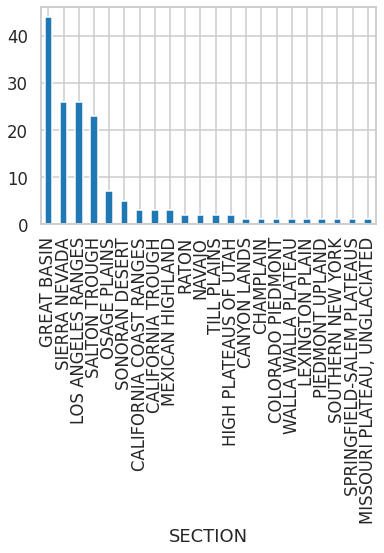

In [334]:
gpd.sjoin(data,physio_US).groupby('SECTION')['mw'].count().sort_values(ascending=False).plot.bar()

Text(0.5, 1.0, 'EQ in Each Section')

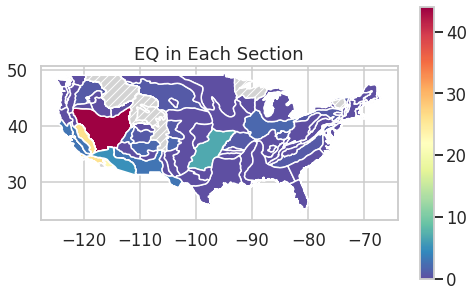

In [365]:
data_phys=gpd.sjoin(data,physio_US,how='right')
data_phys['Section_eq_count']=data_phys.groupby('SECTION')['mw'].transform('count')
fig,ax=plt.subplots(1,1,figsize=(8,5))
data_phys.plot(ax=ax,column='Section_eq_count',
                  missing_kwds={
        "color": "lightgrey",
        "edgecolor": "white",
        "hatch": "///",
        "label": "Missing values",
                             },
               legend=True,cmap='Spectral_r' );
plt.title('EQ in Each Section')


Text(0.5, 1.0, 'mw mean in Each Section')

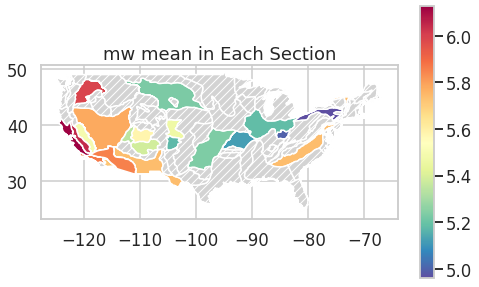

In [367]:
data_phys['Section_mw_mean']=data_phys.groupby('SECTION')['mw'].transform('mean')
fig,ax=plt.subplots(1,1,figsize=(8,5))
data_phys.plot(ax=ax,column='Section_mw_mean',legend=True,
                missing_kwds={
        "color": "lightgrey",
        "edgecolor": "white",
        "hatch": "///",
        "label": "Missing values",
    },
               cmap='Spectral_r' );
plt.title('mw mean in Each Section')


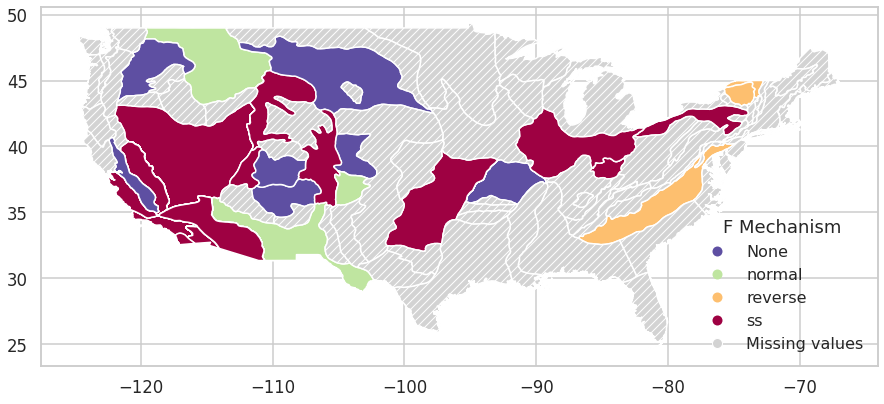

In [440]:
data_phys.plot(column='faultType',legend=True,categorical=True,
               figsize=(15,12),
                missing_kwds={
        "color": "lightgrey",
        "edgecolor": "white",
        "hatch": "///",
        "label": "Missing values",
    },
               cmap='Spectral_r' ,
               legend_kwds={
                   #'bbox_to_anchor':(.3, 1.05),
                    'loc':'lower right',
                   'fontsize':16,
                   'frameon':False,
                   'title':'F Mechanism'
                   });


<AxesSubplot:>

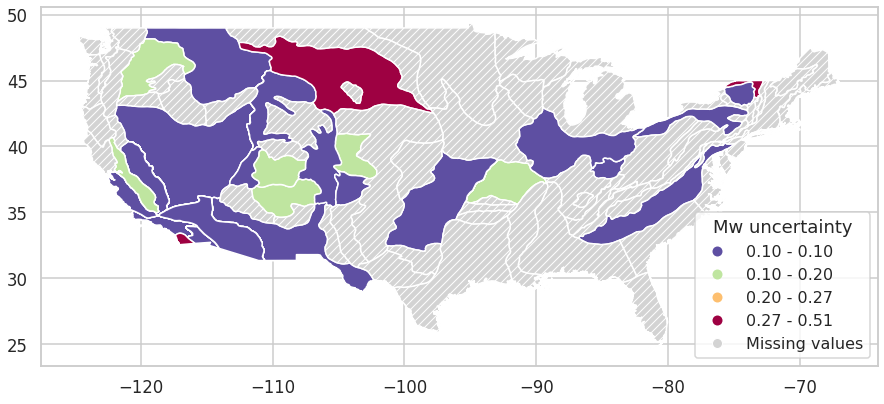

In [438]:
data_phys.plot(column='mw_unc',legend=True,scheme='quantiles',
               figsize=(15,12),
                missing_kwds={
        "color": "lightgrey",
        "edgecolor": "white",
        "hatch": "///",
        "label": "Missing values",
    },
               cmap='Spectral_r' ,
               legend_kwds={
                   #'bbox_to_anchor':(.3, 1.05),
                    'loc':'lower right',
                   'fontsize':16,
                   'title':'Mw uncertainty'
               }
)
                   

# Focal Mechanism

In [197]:
ax1.title.set_text('IRIS_EQ')
fig1.savefig('IRIS_q10.png')

In [198]:
#focal mechanism exmaples
polygon_data=Polygon([(-125, 20), (-125, 50), (-120, 50), (-120,20)]);
#polygon_map=Polygon([(-125, 15), (-125, 70), (-10, 70), (-10,15)]);
polygon_map=Polygon([(-125, 20), (-125, 50), (-115, 50), (-115,20)]);
from obspy.imaging.beachball import beach,beachball
df_fm1=df_fm.dropna().sort_values(by=['lat','lon'],ascending=False).reset_index()
del df_fm1['index']


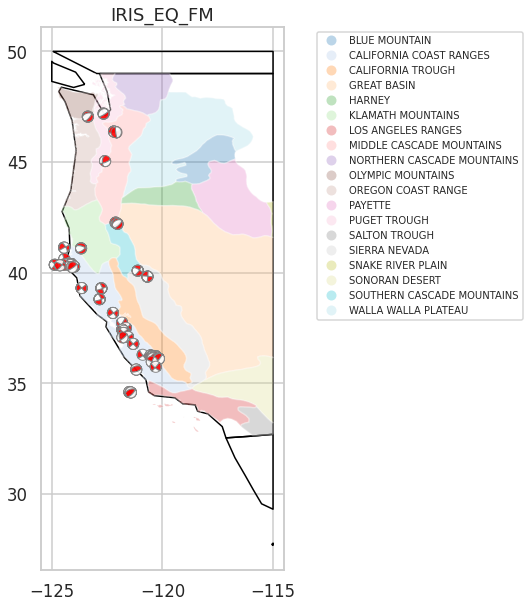

In [199]:
#plot focal mechanism on maps
df_fm_geo = gpd.GeoDataFrame(df_fm1, geometry=gpd.points_from_xy(df_fm1.lon, df_fm1.lat))
df_fm_geo.crs = {'init': 'epsg:4326'}
fig_fm,ax_fm=plt.subplots(figsize=(10,10), subplot_kw={'aspect':'equal'});
df_fm_geo_clip=gpd.clip(df_fm_geo,polygon_data)
physio_US['geometry'] = physio_US.buffer(0)
gpd.clip(regions,polygon_map).plot(ax=ax_fm,facecolor="none", edgecolor="black", linestyle='-',zorder=1)
gpd.clip(physio_US,polygon_map).plot(column='SECTION',ax=ax_fm,alpha=0.3,zorder=2,
                                     label='Physio',
                                     legend=True,
                                     legend_kwds={'fontsize':10},
                                     categorical=True,cmap='tab20');


for row in df_fm_geo_clip.iloc[0:,0:8].itertuples(name=None):
   mt=row[1:4];
   y=row[4];
   x=row[5];
   path='/localdata/rayan/ISC_cataloges_2020/Stressinverse_1'
   out_filename=path+'/Data/IRIS_test.dat'
   #f_mt = float('.'.join(str(ele) for ele in mt))
   with open(out_filename, 'a') as out_file:
     out_file.write(f"  {row[1]:0.2e}  {row[2]:0.2e}  {row[3]:0.2e}\n")
    
   #print('focal mechanism factors mt={0} and lon={1} and lat= {2}'.format(mt,x,y))
   b=beach(mt, xy=(x, y), width=0.5, linewidth=1, alpha=0.9,facecolor='r',edgecolor="gray")
   b.set_zorder(3)
   bc=ax_fm.add_collection(b)
leg=ax_fm.get_legend()
leg.set_bbox_to_anchor((2,1))
ax_fm.title.set_text('IRIS_EQ_FM')
fig_fm.savefig('IRIS_FM.png')  
  
   